NameError: name 'sns' is not defined

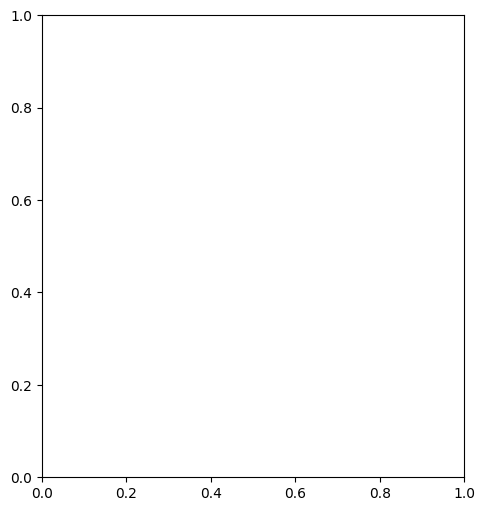

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import TransformedTargetRegressor

# Кастомный трансформер для кластеризации
class ClusterFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=3, add_distances=True):
        self.n_clusters = n_clusters
        self.add_distances = add_distances
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    
    def fit(self, X, y=None):
        self.kmeans.fit(X)
        return self
    
    def transform(self, X, y=None):
        clusters = self.kmeans.predict(X)
        result = np.column_stack([X, clusters])
        
        if self.add_distances:
            distances = self.kmeans.transform(X)
            result = np.column_stack([result, distances])
        
        return result

# Загрузка данных
data = pd.read_csv('dataset_01.csv', sep=';')
X = data[['x1', 'x2', 'x3']]
y = data['y']

# Логарифмическое преобразование целевой переменной
y_log = np.log1p(y)

# Визуализация преобразования
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(y, kde=True, bins=20)
plt.title('Исходное распределение y')
plt.xlabel('y')

plt.subplot(1, 2, 2)
sns.histplot(y_log, kde=True, bins=20)
plt.title('Распределение после логарифмирования')
plt.xlabel('log(y)')

plt.tight_layout()
plt.show()

# Создание пайплайна с кластеризацией и преобразованием цели
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('cluster', ClusterFeatures(n_clusters=2, add_distances=True)),
    ('regressor', Ridge(alpha=0.001))
])

# Обертка для логарифмического преобразования цели
model = TransformedTargetRegressor(
    regressor=pipeline,
    func=np.log1p,      # Преобразование при обучении
    inverse_func=np.expm1  # Обратное преобразование при предсказании
)

# Проверка качества с кросс-валидацией
scores = cross_val_score(
    model, 
    X, 
    y,  # Используем исходные y, преобразование происходит внутри
    cv=5, 
    scoring='neg_max_error'
)
mean_max_error = np.mean(np.abs(scores))

# Обучение финальной модели
model.fit(X, y)
y_pred = model.predict(X)

# Визуализация результатов
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title(f'Предсказания после преобразования\nMax Error: {mean_max_error:.4f}')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.grid(True)

plt.subplot(1, 2, 2)
residuals = y - y_pred
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Остатки модели')
plt.xlabel('Предсказанные значения')
plt.ylabel('Ошибка (y - ŷ)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Анализ важности признаков
try:
    # Получение коэффициентов модели
    ridge_model = model.regressor_.named_steps['regressor']
    coefficients = ridge_model.coef_
    
    # Имена признаков после кластеризации
    feature_names = ['x1', 'x2', 'x3', 'cluster']
    if model.regressor_.named_steps['cluster'].add_distances:
        feature_names += [f'dist_to_centroid_{i}' for i in range(model.regressor_.named_steps['cluster'].n_clusters)]
    
    # Визуализация важности признаков
    plt.figure(figsize=(10, 6))
    sorted_idx = np.argsort(np.abs(coefficients))
    plt.barh(np.array(feature_names)[sorted_idx], np.abs(coefficients)[sorted_idx])
    plt.title('Важность признаков (абсолютные значения коэффициентов)')
    plt.xlabel('Абсолютное значение коэффициента')
    plt.grid(axis='x', alpha=0.3)
    plt.show()
    
except Exception as e:
    print(f"Не удалось визуализировать важность признаков: {e}")

print(f"Усредненная максимальная ошибка: {mean_max_error:.6f}")

if mean_max_error <= 0.22:
    print("Модель удовлетворяет условию задачи!")
else:
    print("Модель не достигла целевого порога 0.22")